In [1]:
%pip install pandas_datareader
%pip install seaborn
%pip install pyupbit
%pip install statsmodels
%pip install pmdarima
%pip install itertools

import os
import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

import itertools
import pyupbit as pb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


Note: you may need to restart the kernel to use updated packages.


In [2]:
df=pb.get_ohlcv("KRW-BTC", interval = "day", count = 1097, to = '20221202')
df

,open,high,low,close,volume,value
2019-11-30 09:00:00,9035000.0,9106000.0,8726000.0,8838000.0,2495.787933,2.230524e+10
2019-12-01 09:00:00,8838000.0,8840000.0,8480000.0,8630000.0,3023.698278,2.606601e+10
2019-12-02 09:00:00,8630000.0,8705000.0,8415000.0,8585000.0,1837.439258,1.571477e+10
2019-12-03 09:00:00,8590000.0,8700000.0,8520000.0,8607000.0,1641.815953,1.414423e+10
2019-12-04 09:00:00,8607000.0,8996000.0,8432000.0,8515000.0,5171.381015,4.477820e+10
...,...,...,...,...,...,...
2022-11-26 09:00:00,22677000.0,22862000.0,22605000.0,22660000.0,2148.775806,4.886589e+10
2022-11-27 09:00:00,22646000.0,22774000.0,22605000.0,22646000.0,1989.051138,4.517556e+10
2022-11-28 09:00:00,22661000.0,22690000.0,22217000.0,22339000.0,3579.090571,8.021448e+10
2022-11-29 09:00:00,22329000.0,22617000.0,22155000.0,22417000.0,2523.908210,5.664776e+10


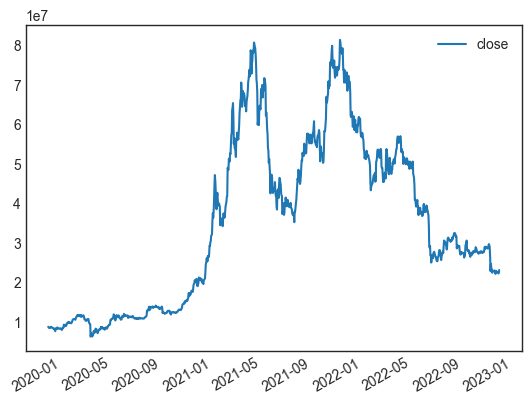

In [3]:
bitcoin_df= df.loc[:,['close']] #사용할 컬럼만 추출
bitcoin_df
fig = bitcoin_df.plot()

In [4]:
# Train Test = 8:2
from sklearn.model_selection import train_test_split
bitcoin_data_train, bitcoin_data_test = train_test_split(bitcoin_df, test_size=0.2, shuffle=False)
print(bitcoin_data_train)
print(bitcoin_data_test)

                          close
2019-11-30 09:00:00   8838000.0
2019-12-01 09:00:00   8630000.0
2019-12-02 09:00:00   8585000.0
2019-12-03 09:00:00   8607000.0
2019-12-04 09:00:00   8515000.0
...                         ...
2022-04-20 09:00:00  51388000.0
2022-04-21 09:00:00  50805000.0
2022-04-22 09:00:00  49937000.0
2022-04-23 09:00:00  49742000.0
2022-04-24 09:00:00  49620000.0

[877 rows x 1 columns]
                          close
2022-04-25 09:00:00  50614000.0
2022-04-26 09:00:00  48777000.0
2022-04-27 09:00:00  49954000.0
2022-04-28 09:00:00  50580000.0
2022-04-29 09:00:00  49731000.0
...                         ...
2022-11-26 09:00:00  22660000.0
2022-11-27 09:00:00  22646000.0
2022-11-28 09:00:00  22339000.0
2022-11-29 09:00:00  22417000.0
2022-11-30 09:00:00  23192000.0

[220 rows x 1 columns]


// 개략적인 모델 구축

train, test data를 먼저 스플릿/
추후 검정을 위해 분리/
타임 시리즈 데이터이기 때문에 shuffle은 하지 않는다./
뒷단에 20%가 예측에 활용될 수 있도록 구성

- test_size: 테스트 셋 구성의 비율을 나타냅니다. train_size의 옵션과 반대 관계에 있는 옵션 값이며, 주로 test_size를 지정해 줍니다. 0.2는 전체 데이터 셋의 20%를 test (validation) 셋으로 지정하겠다는 의미입니다. default 값은 0.25 입니다.
- shuffle: default=True 입니다. split을 해주기 이전에 섞을건지 여부입니다. 보통은 default 값으로 놔둡니다.
- stratify: default=None 입니다. classification을 다룰 때 매우 중요한 옵션값입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. (한 쪽에 쏠려서 분배되는 것을 방지합니다) 만약 이 옵션을 지정해 주지 않고 classification 문제를 다룬다면, 성능의 차이가 많이 날 수 있습니다.
- random_state: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있습니다.


In [5]:
#n_obs= 20
#bitcoin_data_train, bitcoin_data_test = bitcoin_df[0:-n_obs], bitcoin_df[-n_obs:]
import matplotlib.pyplot as plt #adf테스트를 먼저해서 정상인지 확인
from statsmodels.tsa.stattools import adfuller

def ADF(bitcoin_df): #ADF검정 
    result = adfuller(bitcoin_df, autolag="AIC")
    
    print('---- Adfuller ----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' %result[3])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
ADF(bitcoin_df)

---- Adfuller ----
ADF Statistic: -1.588362
p-value: 0.4894368580
Lag: 5
observation: 1091
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [6]:
print(bitcoin_data_train)
print(bitcoin_data_test)

                          close
2019-11-30 09:00:00   8838000.0
2019-12-01 09:00:00   8630000.0
2019-12-02 09:00:00   8585000.0
2019-12-03 09:00:00   8607000.0
2019-12-04 09:00:00   8515000.0
...                         ...
2022-04-20 09:00:00  51388000.0
2022-04-21 09:00:00  50805000.0
2022-04-22 09:00:00  49937000.0
2022-04-23 09:00:00  49742000.0
2022-04-24 09:00:00  49620000.0

[877 rows x 1 columns]
                          close
2022-04-25 09:00:00  50614000.0
2022-04-26 09:00:00  48777000.0
2022-04-27 09:00:00  49954000.0
2022-04-28 09:00:00  50580000.0
2022-04-29 09:00:00  49731000.0
...                         ...
2022-11-26 09:00:00  22660000.0
2022-11-27 09:00:00  22646000.0
2022-11-28 09:00:00  22339000.0
2022-11-29 09:00:00  22417000.0
2022-11-30 09:00:00  23192000.0

[220 rows x 1 columns]


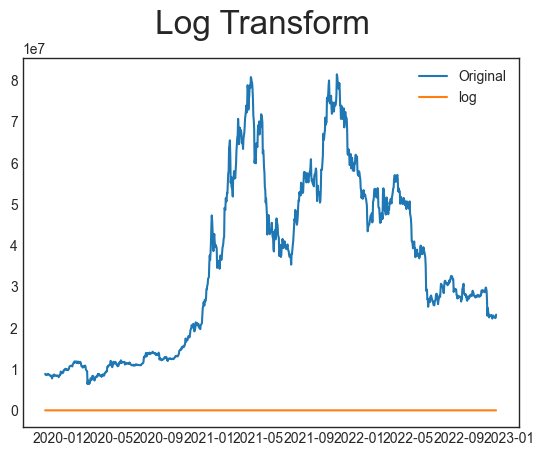

In [7]:
import numpy as np
log_bitcoin_data_train = bitcoin_data_train.copy()
log_bitcoin_data_train =np.log(bitcoin_df) #로그변환
plt.plot(bitcoin_df, label='Original')
plt.plot(log_bitcoin_data_train,label='log')
plt.suptitle("Log Transform", size= 24)
plt.legend()
plt.show()

In [8]:
diff_bitcoin_data_train = log_bitcoin_data_train.copy() #차분
diff_bitcoin_data_train = diff_bitcoin_data_train.diff()
diff_bitcoin_data_train = diff_bitcoin_data_train.dropna() #결측치 제거
print('##### Raw Data #####')
print(bitcoin_data_train)
print('##### Differenced Data #####')
print(diff_bitcoin_data_train)

##### Raw Data #####
                          close
2019-11-30 09:00:00   8838000.0
2019-12-01 09:00:00   8630000.0
2019-12-02 09:00:00   8585000.0
2019-12-03 09:00:00   8607000.0
2019-12-04 09:00:00   8515000.0
...                         ...
2022-04-20 09:00:00  51388000.0
2022-04-21 09:00:00  50805000.0
2022-04-22 09:00:00  49937000.0
2022-04-23 09:00:00  49742000.0
2022-04-24 09:00:00  49620000.0

[877 rows x 1 columns]
##### Differenced Data #####
                        close
2019-12-01 09:00:00 -0.023816
2019-12-02 09:00:00 -0.005228
2019-12-03 09:00:00  0.002559
2019-12-04 09:00:00 -0.010747
2019-12-05 09:00:00  0.019768
...                       ...
2022-11-26 09:00:00 -0.000706
2022-11-27 09:00:00 -0.000618
2022-11-28 09:00:00 -0.013649
2022-11-29 09:00:00  0.003486
2022-11-30 09:00:00  0.033988

[1096 rows x 1 columns]


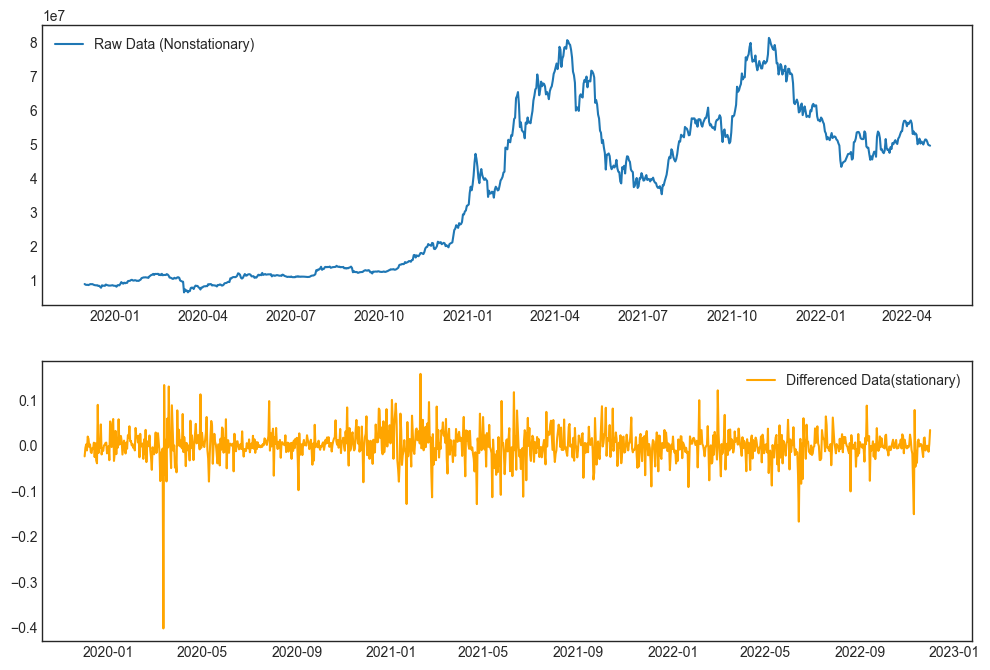

In [9]:
# Differenced data plot

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(bitcoin_data_train['close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_bitcoin_data_train, 'orange') #첫번째 차분 (t- (t-1))
plt.legend(['Differenced Data(stationary)'])
plt.show()

c:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


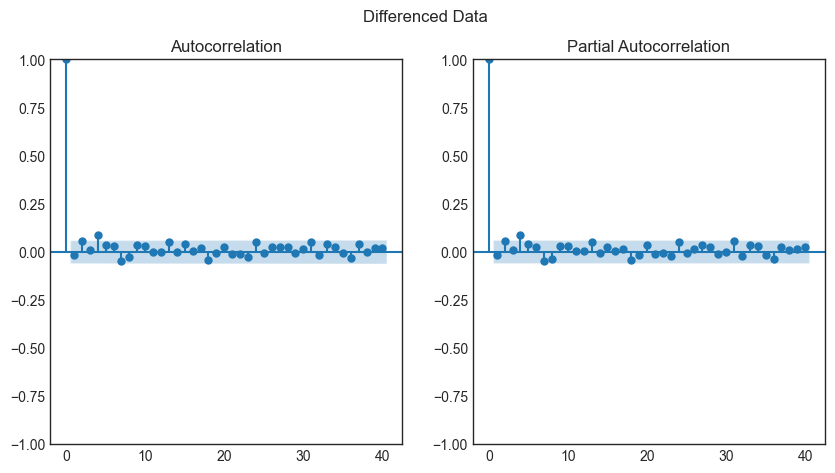

In [10]:
fig, ax= plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_bitcoin_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_bitcoin_data_train.values.squeeze(), lags=40, ax=ax[1]);

In [11]:
import matplotlib.pyplot as plt #adf테스트를 먼저해서 정상인지 확인
from statsmodels.tsa.stattools import adfuller

def ADF(bitcoin_df): #ADF검정 
    result = adfuller(bitcoin_df, autolag="AIC")
    
    print('---- Adfuller ----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' %result[3])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
ADF(diff_bitcoin_data_train)

---- Adfuller ----
ADF Statistic: -14.694763
p-value: 0.0000000000
Lag: 3
observation: 1092
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [12]:
#파라미터 Search

auto_arima_model = auto_arima(bitcoin_data_train, start_p=1, start_q=1,
                             max_p=3, max_q=3,seasona=False,
                             d=1,
                             trace= True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=27312.978, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=27310.693, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=27312.174, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=27310.723, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=27310.884, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=27310.576, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=27312.598, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=27309.489, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=27312.478, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=27312.576, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=27312.423, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=27309.404, Time=0.67 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=27310.548, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=27310.528, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=27312.264, Time=0.54

In [13]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  877
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -13647.702
Date:                Mon, 05 Dec 2022   AIC                          27309.404
Time:                        02:26:55   BIC                          27342.831
Sample:                    11-30-2019   HQIC                         27322.190
                         - 04-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.924e+04   3.72e+04      1.054      0.292   -3.37e+04    1.12e+05
ar.L1          0.9054      0.185      4.899      0.000       0.543       1.268
ar.L2         -0.5335      0.173     -3.078      0.002      -0.873      -0.194
ma.L1         -0.8432      0.186     -4.530      0.000      -1.208      -0.478
ma.L2          0.4469      0.174      2.571      0.010       0.106       0.788
ma.L3          0.1184      0.030      3.957      0.000       0.060       0.177
sigma2      2.026e+12      0.001   3.86e+15      0.000    2.03e+12    2.03e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1239.22
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              20.80   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.62e+31. Standard errors may be unstable.
"""

In [14]:
print(bitcoin_data_train)
print(bitcoin_data_test)

                          close
2019-11-30 09:00:00   8838000.0
2019-12-01 09:00:00   8630000.0
2019-12-02 09:00:00   8585000.0
2019-12-03 09:00:00   8607000.0
2019-12-04 09:00:00   8515000.0
...                         ...
2022-04-20 09:00:00  51388000.0
2022-04-21 09:00:00  50805000.0
2022-04-22 09:00:00  49937000.0
2022-04-23 09:00:00  49742000.0
2022-04-24 09:00:00  49620000.0

[877 rows x 1 columns]
                          close
2022-04-25 09:00:00  50614000.0
2022-04-26 09:00:00  48777000.0
2022-04-27 09:00:00  49954000.0
2022-04-28 09:00:00  50580000.0
2022-04-29 09:00:00  49731000.0
...                         ...
2022-11-26 09:00:00  22660000.0
2022-11-27 09:00:00  22646000.0
2022-11-28 09:00:00  22339000.0
2022-11-29 09:00:00  22417000.0
2022-11-30 09:00:00  23192000.0

[220 rows x 1 columns]


In [15]:
prediction = auto_arima_model.predict(len(bitcoin_data_test),return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(bitcoin_data_test.index)
predict_index[0]

Timestamp('2022-04-25 09:00:00')

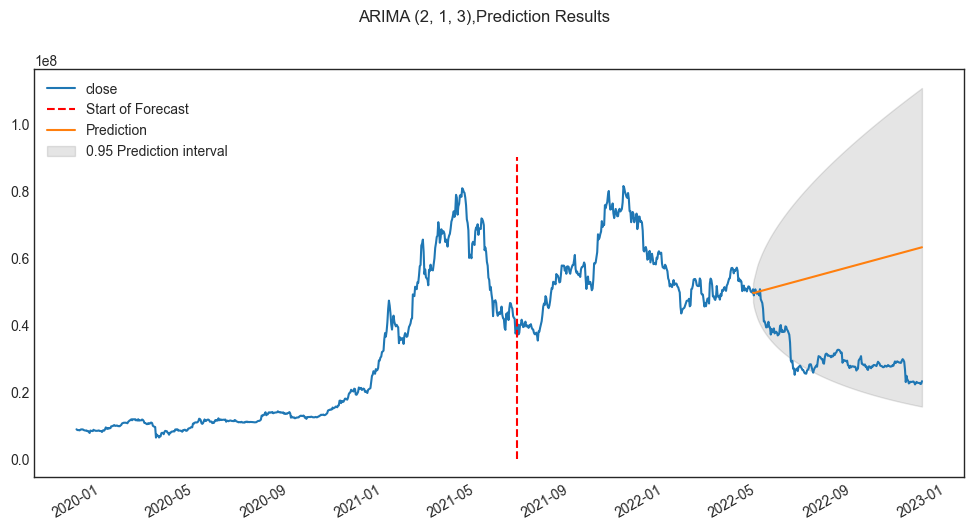

In [16]:
fig, ax = plt.subplots(figsize= (12, 6))
bitcoin_df.plot(ax=ax);
ax.vlines('2021-06-23',0,90000000.0, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order},Prediction Results')
plt.show()

정확하게 잡아내기는 어려웠지만 제공하는 프레딕션 인터벌 안에 실제 테스트 셋이 포함되어 있는 것을 알 수 있었습니다.                                                                                                                                          

2022/05/26
- 2022년 1월부터로 트레이닝 시켜보기 /in[16]확인해보기
- 환율같은 거 넣고 해보기 